In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
import copy

# The goal of the notebook is to compare FIR filtering with Morlet Wavelet filtering methods. Input is the raw signal and its filtered versions, the goal
# is to filter the raw signal and reproduce as close as possible its FIR and MW filtered representations

dict_keys(['__header__', '__version__', '__globals__', 'signal', 'signalFIR', 'signalMW', 'srate'])
12288 12288 12288 2048


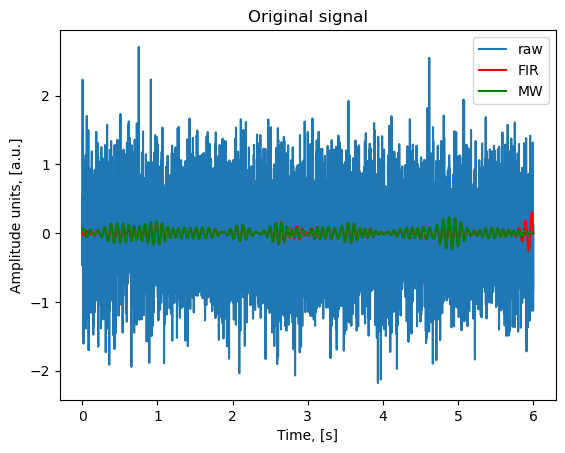

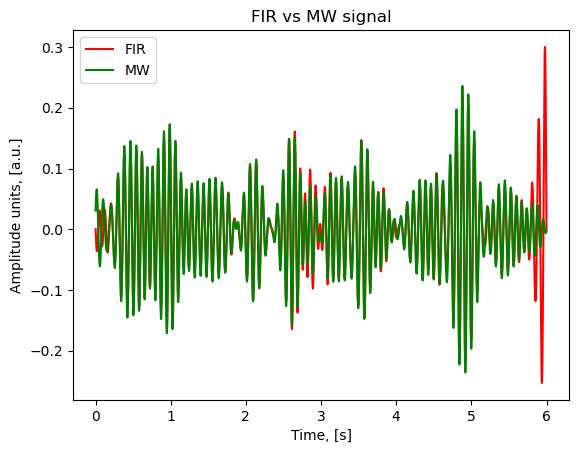

In [10]:
# load and see data

data = sio.loadmat(r'C:\Users\GIANNI\Desktop\DSP applications on Matlab and Python\Section 7_Wavelet Analysis\sigprocMXC_wavelets\wavelet_codeChallenge')
print(data.keys())

raw = np.array(data['signal']).flatten()
FIRsignal = np.array(data['signalFIR']).flatten()
MWsignal = np.array(data['signalMW']).flatten()
fs = int(data['srate'])
N = len(raw)
tv = np.arange(0, N/fs, 1/fs)
# debug 
print(N, len(FIRsignal), len(MWsignal), fs)


plt.figure()
plt.title('Original signal')
plt.plot(tv, raw, label = 'raw')
plt.plot(tv, FIRsignal,'r', label = 'FIR')
plt.plot(tv, MWsignal, 'g', label = 'MW')
plt.legend()
plt.xlabel('Time, [s]')
plt.ylabel('Amplitude units, [a.u.]')
plt.show()

plt.figure()
plt.title('FIR vs MW signal')
plt.plot(tv, FIRsignal, 'r', label = 'FIR')
plt.plot(tv, MWsignal, 'g', label = 'MW')
plt.legend()
plt.xlabel('Time, [s]')
plt.ylabel('Amplitude units, [a.u.]')
plt.show()


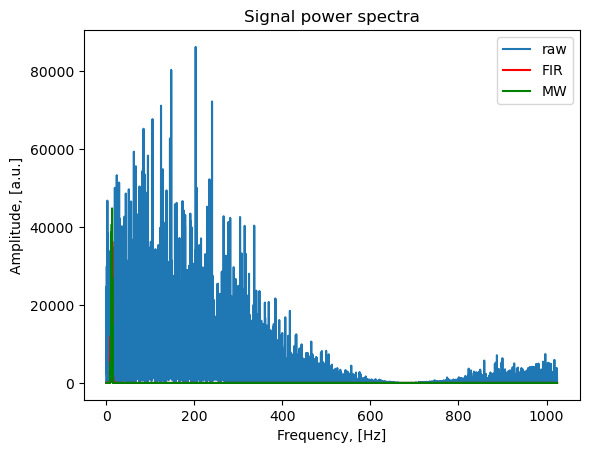

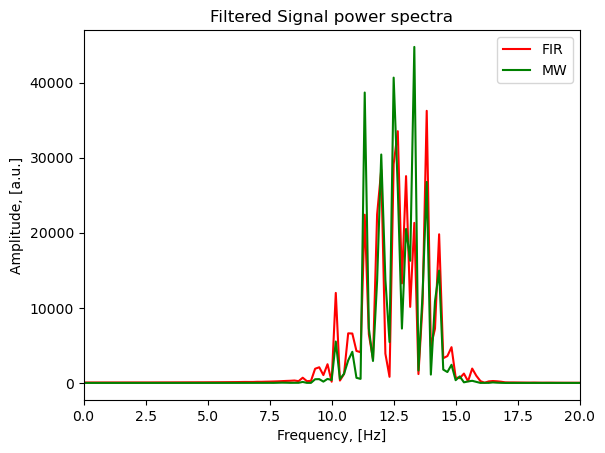

In [11]:
nyquist = fs/2
hz = np.linspace(0, nyquist, N//2 + 1)

rawpow = np.abs(scipy.fftpack.fft(raw))**2
FIRpow = np.abs(scipy.fftpack.fft(FIRsignal))**2
MWpow = np.abs(scipy.fftpack.fft(MWsignal))**2

plt.figure()
plt.title('Signal power spectra')
plt.plot(hz, rawpow[:len(hz)], label = 'raw')
plt.plot(hz, FIRpow[:len(hz)], 'r', label = 'FIR')
plt.plot(hz, MWpow[:len(hz)], 'g', label = 'MW')
plt.legend()
plt.xlabel('Frequency, [Hz]')
plt.ylabel('Amplitude, [a.u.]')
plt.show()

plt.figure()
plt.title('Filtered Signal power spectra')
plt.plot(hz, FIRpow[:len(hz)], 'r', label = 'FIR')
plt.plot(hz, MWpow[:len(hz)], 'g', label = 'MW')
plt.legend()
plt.xlabel('Frequency, [Hz]')
plt.ylabel('Amplitude, [a.u.]')
plt.xlim([0, 20])
plt.show()

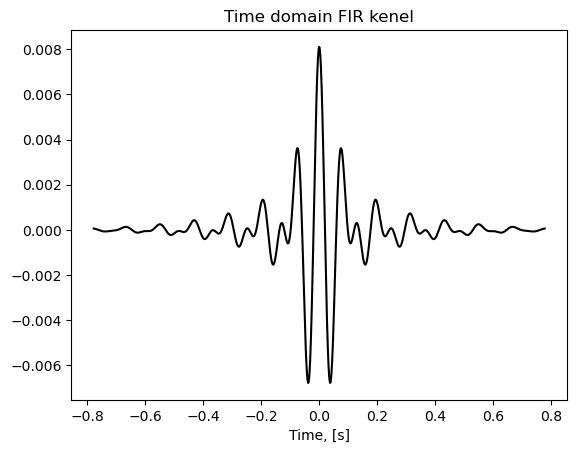

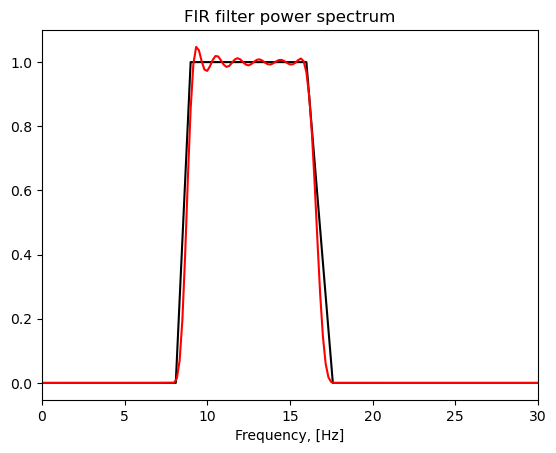

In [12]:

# FIR filter design

band = [9, 16]
slope = .1
order = np.round(14*fs/band[0])

if order%2 == 0:
    order += 1      # order must be odd


shape = [0,0,1,1,0,0]
frex =  [0, band[0] - slope*band[0], band[0], band[1], band[1] + slope*band[1], nyquist]

# filter in time domain
kernel = scipy.signal.firls(order, frex, shape, fs = fs)


# plot filter in time domain

plt.figure()
plt.title('Time domain FIR kenel')
plt.plot(np.arange(-order/2, order/2)/fs, kernel, 'k')
plt.xlabel('Time, [s]')
plt.show()

# kernel power spectrum
kernspectra = np.abs(scipy.fftpack.fft(kernel, len(tv)))**2

# plot power spectrum

plt.figure()
plt.title('FIR filter power spectrum')
plt.plot(np.array(frex), shape, 'k-')
plt.plot(hz, kernspectra[:len(hz)], 'r')
plt.xlabel('Frequency, [Hz]')
plt.xlim([0,30])
plt.show()



3187 12288 (12288,)


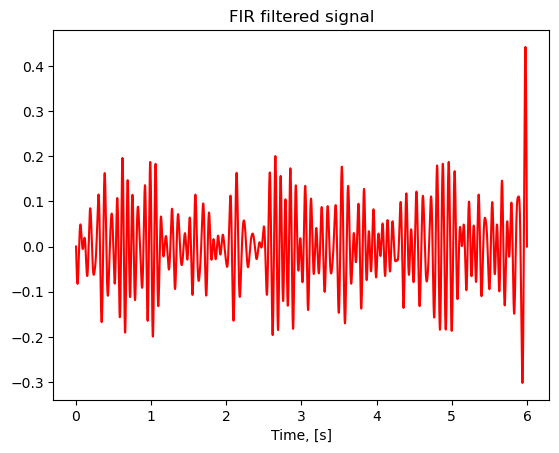

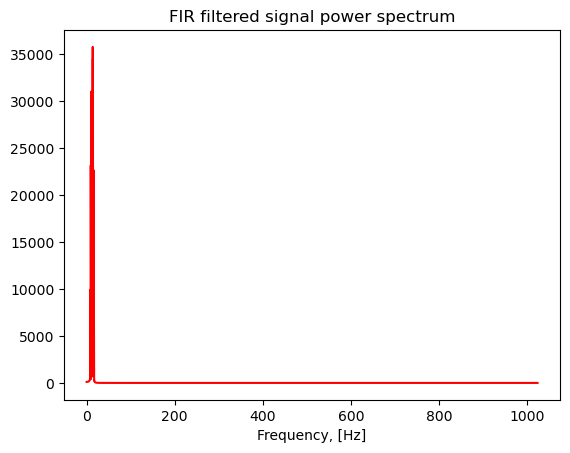

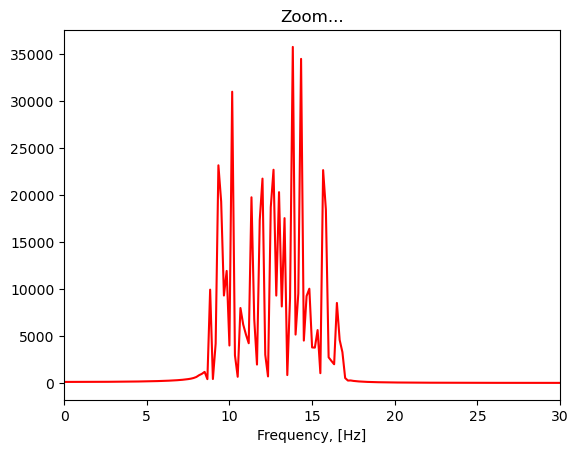

In [13]:
# now apply filter to the data

# debug vector lengths 
print(len(kernel), len(raw), raw.shape)

# apply filter
filteredFIR = scipy.signal.filtfilt(kernel, 1, raw)

# plot in time domain

plt.figure()
plt.title('FIR filtered signal')
plt.plot(tv, filteredFIR, 'r')
plt.xlabel('Time, [s]')
plt.show()

# power spectra and plotting (always remember to specify the numer of points according to the number of points of the signal in time domain)
FIRspectrum = np.abs(scipy.fftpack.fft(filteredFIR, len(tv)))**2 

plt.figure()
plt.title('FIR filtered signal power spectrum')
plt.plot(hz, FIRspectrum[:len(hz)], 'r')
plt.xlabel('Frequency, [Hz]')
plt.show()

plt.figure()
plt.title('Zoom...')
plt.plot(hz, FIRspectrum[:len(hz)], 'r')
plt.xlabel('Frequency, [Hz]')
plt.xlim([0,30])
plt.show()


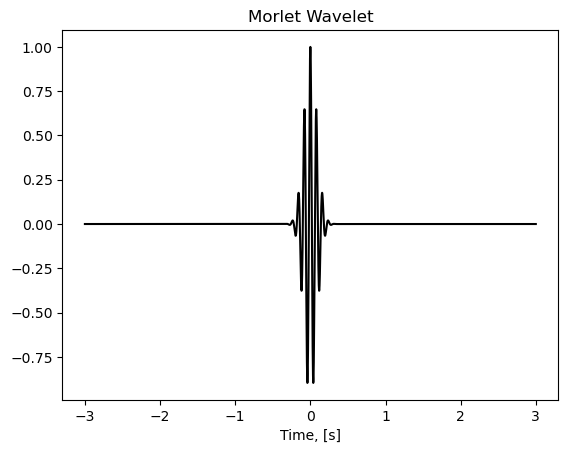

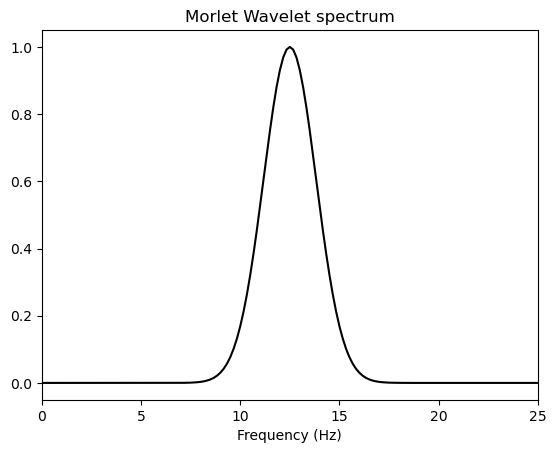

In [14]:
# now let's try Morlet Wavelet

fpeak = 12.5
timevec = tv - np.mean(tv) # centered around zero for wavelets
csw  = np.cos(2*np.pi*fpeak*timevec) # cosine wave
fwhm = .2 # full-width at half-maximum in seconds
gaussian = np.exp( -(4*np.log(2)*timevec**2) / fwhm**2 ) # Gaussian

MorWav = csw * gaussian

# plot time domain wavelet
plt.figure()
plt.title('Morlet Wavelet')
plt.plot(timevec, MorWav, 'k')
plt.xlabel('Time, [s]')
plt.show()

# power spectrum
wavehz = np.linspace(0,nyquist,int(np.floor(len(timevec)/2)+1))
morwavX = np.abs(scipy.fftpack.fft(MorWav))**2

# normalize
morwavX = morwavX / np.abs(np.max(morwavX))

plt.figure()
plt.title('Morlet Wavelet spectrum')
plt.plot(wavehz,morwavX[:len(wavehz)],'k')
plt.xlim([0,fpeak*2])
plt.xlabel('Frequency (Hz)')
plt.show()


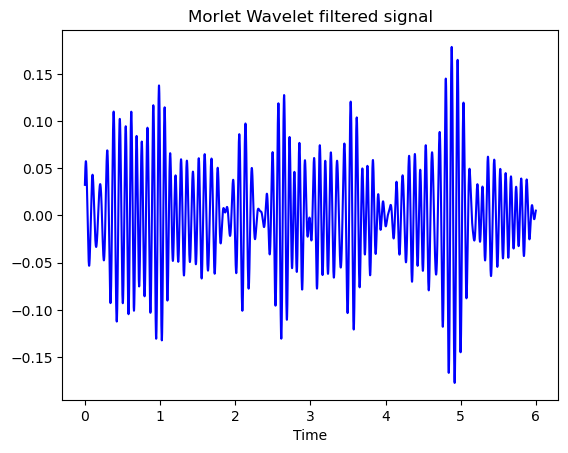

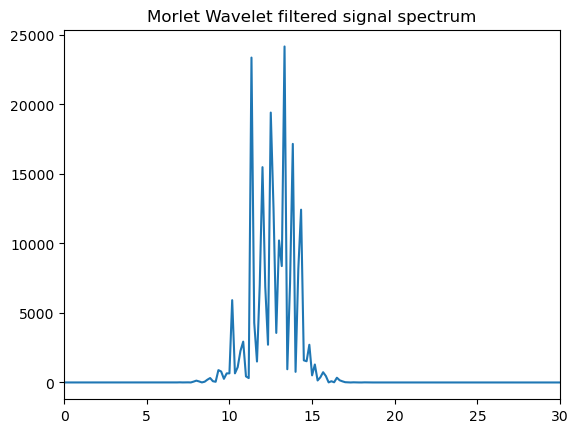

In [15]:
# now let's use it to filter the data 

nconv = len(raw) + len(timevec) - 1
halfw = int( np.floor(len(timevec)/2) )

MorwavX = scipy.fftpack.fft(MorWav,nconv)
MorwavX = MorwavX / np.abs(np.max(MorwavX))

# now for the rest of convolution
convres = scipy.fftpack.ifft( MorwavX * scipy.fftpack.fft(raw,nconv) )
convres = np.real( convres[halfw:-halfw+1] )


# time domain
plt.figure()
plt.title('Morlet Wavelet filtered signal')
plt.plot(tv,convres,'b')
plt.xlabel('Time')
plt.show()

# frequency domain
plt.figure()
plt.title('Morlet Wavelet filtered signal spectrum')
convresX = np.abs(scipy.fftpack.fft(convres))**2
plt.plot(hz,convresX[:len(hz)])
plt.xlim([0,30])
plt.show()


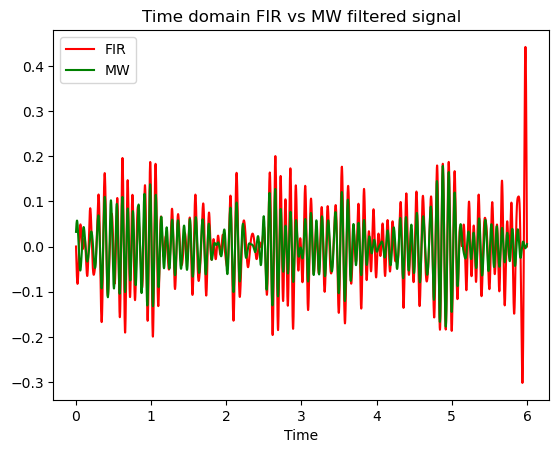

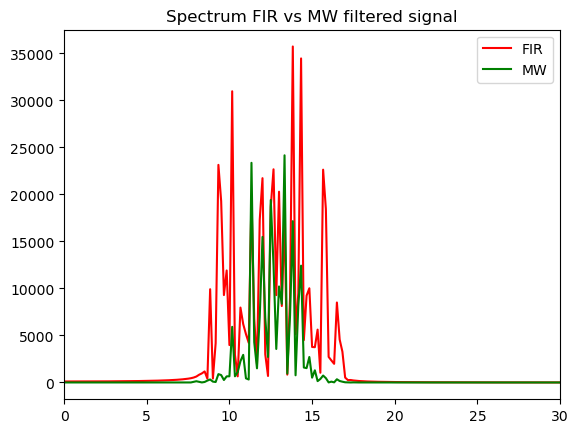

In [8]:
# now compare two signals

plt.figure()
plt.title('Time domain FIR vs MW filtered signal')
plt.plot(tv,filteredFIR, 'r', label = 'FIR')
plt.plot(tv,convres,'g', label = 'MW')
plt.xlabel('Time')
plt.legend()
plt.show()


plt.figure()
plt.title('Spectrum FIR vs MW filtered signal')
plt.plot(hz, FIRspectrum[:len(hz)], 'r', label = 'FIR')
plt.plot(hz,convresX[:len(hz)], 'g', label = 'MW')
plt.legend()
plt.xlim([0,30])
plt.show()
